In [1]:
import numpy as np
import pandas as pd
import scanpy.api as sc
import matplotlib.pyplot as plt
from anndata import AnnData



sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80, color_map='viridis')
sc.logging.print_versions()

scanpy==1.2.2 anndata==0.6.6 numpy==1.14.0rc1 scipy==1.1.0 pandas==0.23.4 scikit-learn==0.19.2 statsmodels==0.9.0 python-igraph==0.7.1 louvain==0.6.1 


### Import csv files

In [2]:
data_rep1 = pd.read_csv('GSM2743164_rep1_colon_rnaseq.csv')
#data_rep2 = pd.read_csv('GSM2743165_rep2_colon_rnaseq.csv')

### Preprocessing

In [3]:
# cells should be rows and genes should be columns, so need to transpose the csv file

data_rep1 = data_rep1.T
data_rep1.columns = data_rep1.values[0,:]

print ('columns')
print (data_rep1.columns)
print ('index')
print (data_rep1.index[1:])
print ('values')
print (data_rep1.values)
print ('adjusted values')
print (data_rep1.values[1:,:])

adata = AnnData(X=data_rep1.values[1:,:])
adata.obs_names = data_rep1.index[1:]
adata.var_names = data_rep1.columns

columns
Index(['0610006L08Rik', '0610007P14Rik', '0610009B22Rik', '0610009E02Rik',
       '0610009L18Rik', '0610009O20Rik', '0610010F05Rik', '0610010K14Rik',
       '0610011F06Rik', '0610012D04Rik',
       ...
       'mt-Co2', 'mt-Co3', 'mt-Cytb', 'mt-Nd1', 'mt-Nd2', 'mt-Nd3', 'mt-Nd4',
       'mt-Nd4l', 'mt-Nd5', 'mt-Nd6'],
      dtype='object', length=25504)
index
Index(['tmouse_   1', 'tmouse_   2', 'tmouse_   3', 'tmouse_   4',
       'tmouse_   5', 'tmouse_   6', 'tmouse_   7', 'tmouse_   8',
       'tmouse_   9', 'tmouse_  10',
       ...
       'tmouse_1729', 'tmouse_1730', 'tmouse_1731', 'tmouse_1732',
       'tmouse_1733', 'tmouse_1734', 'tmouse_1735', 'tmouse_1736',
       'tmouse_1737', 'tmouse_1738'],
      dtype='object', length=1738)
values
[['0610006L08Rik' '0610007P14Rik' '0610009B22Rik' ... 'mt-Nd4l' 'mt-Nd5'
  'mt-Nd6']
 [0 1 0 ... 4 15 0]
 [0 2 2 ... 7 23 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 2 5 0]]
adjusted values
[[0 1 0 ... 4 15 0]
 [0 2 2 ...

In [4]:
sc.pp.filter_cells(adata, min_genes=200)

In [5]:
adata

AnnData object with n_obs × n_vars = 1738 × 25504 
    obs: 'n_genes'

Plot some information about mitochondrial genes, important for quality control. 

In [6]:
mito_genes = [name for name in adata.var_names if name.startswith('mt-')]
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary, as X is sparse - it transform to a dense array after summing
adata.obs['percent_mito'] = np.sum(
    adata[:, mito_genes].X, axis=1) / np.sum(adata.X, axis=1)
# add the total counts per cell as observations-annotation to adata
adata.obs['n_counts'] = adata.X.sum(axis=1)


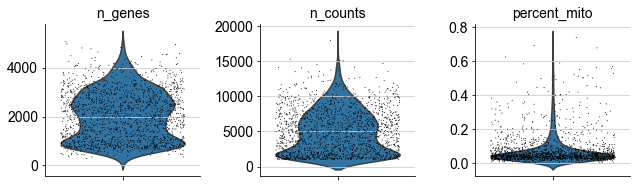

In [7]:
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'],
             jitter=0.4, multi_panel=True)

Remove cells that have too many mitochondrial genes expressed or too many total counts.



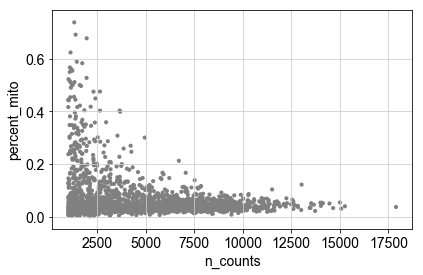

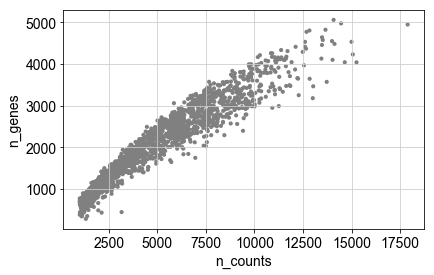

In [8]:
sc.pl.scatter(adata, x='n_counts', y='percent_mito')
sc.pl.scatter(adata, x='n_counts', y='n_genes')

In [9]:
# Filtering
#adata = adata[adata.obs['n_genes'] < 2500, :]
#adata = adata[adata.obs['percent_mito'] < 0.05, :]

In [10]:
adata.raw = sc.pp.log1p(adata, copy=True)

Normalize data matrix by cell (total cells = 10,000)

In [11]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)

Identify highly-variable genes.

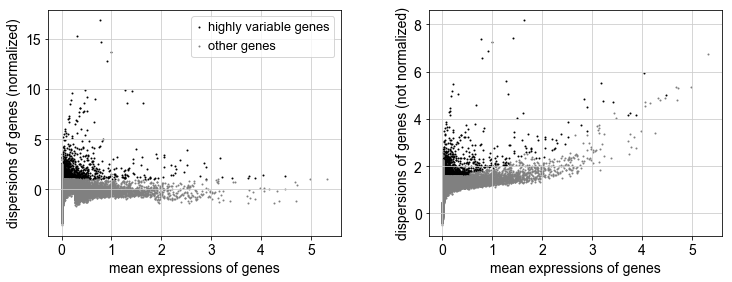

In [12]:
filter_result = sc.pp.filter_genes_dispersion(
    adata.X, min_mean=0.0125, max_mean=10, min_disp=1)
sc.pl.filter_genes_dispersion(filter_result)

Actually do the filtering.

In [13]:
adata = adata[:, filter_result.gene_subset]

Logarithmize the data.

In [14]:
sc.pp.log1p(adata)

In [15]:
adata

View of AnnData object with n_obs × n_vars = 1738 × 1805 
    obs: 'n_genes', 'percent_mito', 'n_counts'

In [16]:
sc.pp.scale(adata, max_value=10)

### PCA

In [17]:
sc.tl.pca(adata)

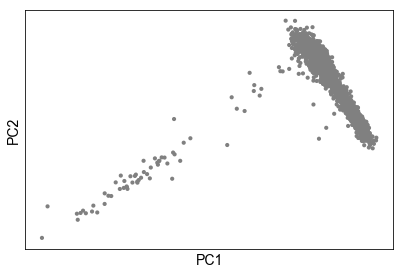

In [18]:
adata.obsm['X_pca'] *= -1  # multiply by -1 to match Seurat
sc.pl.pca_scatter(adata)

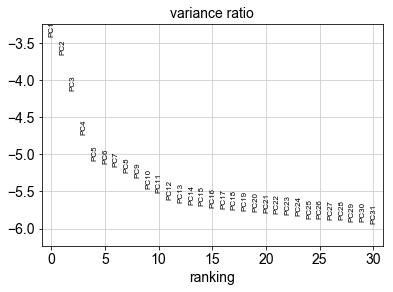

In [19]:
sc.pl.pca_variance_ratio(adata, log=True)

In [20]:
sc.tl.tsne(adata, random_state=2, n_pcs=10)

computing tSNE
    using 'X_pca' with n_pcs = 10
    using sklearn.manifold.TSNE with a fix by D. DeTomaso
    finished (0:00:46.08) --> added
    'X_tsne', tSNE coordinates (adata.obsm)


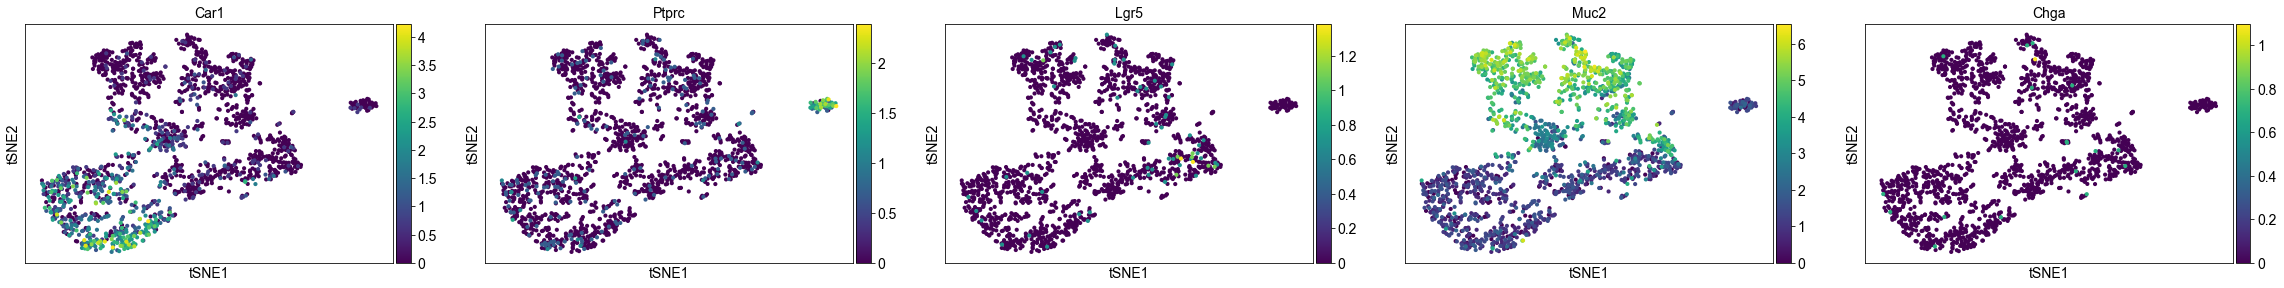

In [21]:
sc.pl.tsne(adata, color=['Car1','Ptprc','Lgr5','Muc2','Chga'])

In [22]:
sc.pp.neighbors(adata, n_neighbors=10)

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished (0:00:04.10) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix


In [23]:
sc.tl.umap(adata)

computing UMAP
    finished (0:00:03.42) --> added
    'X_umap', UMAP coordinates (adata.obsm)


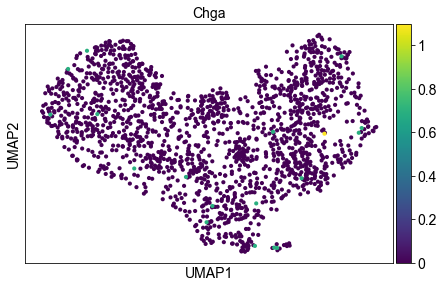

In [24]:
sc.pl.umap(adata, color='Chga')

In [25]:
sc.tl.louvain(adata)

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.14) --> found 11 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)


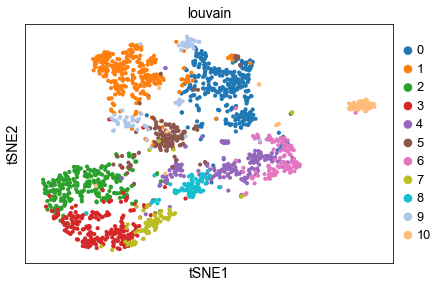

In [26]:
sc.pl.tsne(adata, color='louvain')

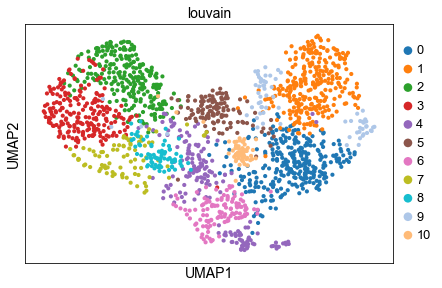

In [27]:
sc.pl.umap(adata, color='louvain')

ranking genes
    finished (0:00:03.84) --> added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
saving figure to file ./figures/rank_genes_groups_louvain.pdf


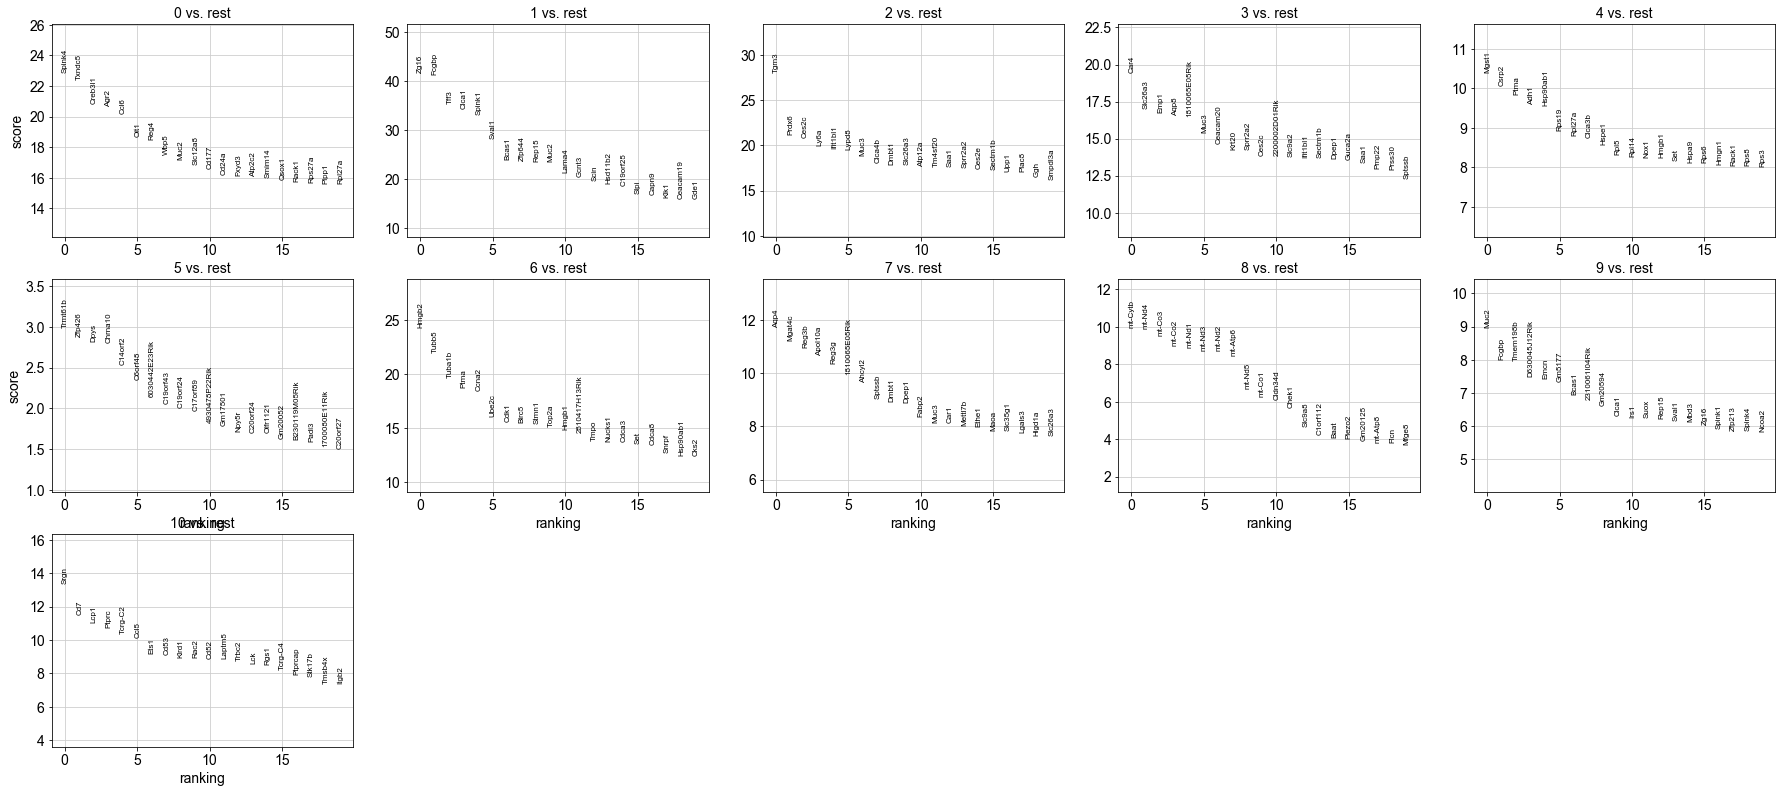

In [29]:
sc.tl.rank_genes_groups(adata, 'louvain')
sc.pl.rank_genes_groups(adata, n_genes=20, save=".pdf")